In [1]:
import os
import torch
import numpy as np
import nglview
import rdkit
from rdkit import Chem
import matplotlib.pyplot as plt
import pandas as pd
from rdkit.Chem import AllChem
from tqdm import tqdm 
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

from torch_geometric.data import Data, Batch 

import nglview
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from ase.visualize import view
from ase import Atoms
from xtb.ase.calculator import XTB

IPythonConsole.ipython_useSVG = True 
IPythonConsole.molSize = 300, 300
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
%matplotlib notebook

In [2]:
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem
import ipywidgets
from ipywidgets import interact, interactive, fixed, IntSlider

In [3]:
def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

In [4]:
def repeat_data(data: Data, num_repeat) -> Batch:
    datas = [deepcopy(data) for i in range(num_repeat)]
    return Batch.from_data_list(datas)

def repeat_batch(batch: Batch, num_repeat) -> Batch:
    datas = batch.to_data_list()
    new_data = []
    for i in range(num_repeat):
        new_data += deepcopy(datas)
    return Batch.from_data_list(new_data)

In [5]:
from e3moldiffusion import chem
from geom.data import GeomDataModule
from geom.train import Trainer

In [6]:
def compute_distances(pos):
    d = torch.cdist(pos, pos)
    ids = torch.triu_indices(pos.size(0), pos.size(0), 1)
    d = torch.triu(d, diagonal=1)
    d = d[ids[0, :], ids[1, :]]
    return d

In [7]:
def compute_mmff_energy(mol):
    ff = AllChem.MMFFGetMoleculeForceField(mol, AllChem.MMFFGetMoleculeProperties(mol), confId=0)
    ff.Initialize()
    out = ff.CalcEnergy()
    return out

In [8]:
!nvidia-smi

Mon Mar  6 07:22:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1A:00.0 Off |                    0 |
| N/A   41C    P0    45W / 300W |      0MiB / 32510MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
!echo "checking if the compute node has access to the hpfs directory where data is stored."
!ls /hpfs/projects/mlcs

checking if the compute node has access to the hpfs directory where data is stored.
2022_deepfrag_collab  CrystalMD       methods_development  ProteinMassSpecPred
cct		      e3moldiffusion  pdm		   README-PROJECTS.txt
cct-working	      mdse	      potency_prediction   sms_workspace


In [10]:
device = "cuda:0"
# device = "cpu"

In [11]:
datapath = "/hpfs/projects/mlcs/e3moldiffusion/"
test_info_df = os.path.join(datapath, "qm9", "test_info.csv")
test_info_df = pd.read_csv(test_info_df)
smiles_to_mol_id = os.path.join(datapath, "qm9", "smiles_to_mol_id.csv")
smiles_to_mol_id = pd.read_csv(smiles_to_mol_id)
smiles_to_mol_id = {i:s for i, s in zip(smiles_to_mol_id.mol_id, smiles_to_mol_id.smiles)}
test_info_df["smiles"] = test_info_df["mol_id"].map(lambda x: smiles_to_mol_id.get(x))

In [12]:
dataset = "qm9"
# dataset = "drugs"

In [13]:
datamodule = GeomDataModule(
        batch_size=1,
        num_workers=1,
        dataset=dataset,
        env_in_init=True,
        shuffle_train=True,
        max_num_conformers=30
    )
datamodule.setup()

In [14]:
print(f"Training set. Number of structures: {len(datamodule.train_dataset)}")
print(f"Validation set. Number of structures: {len(datamodule.val_dataset)}")
print(f"Test set. Number of structures: {len(datamodule.test_dataset)}")

Training set. Number of structures: 879934
Validation set. Number of structures: 98228
Test set. Number of structures: 12882


In [15]:
run = 10

In [16]:
model = Trainer.load_from_checkpoint(f'logs/{dataset}_coords/run{str(run)}/last.ckpt', strict=False).to(device)
model = model.eval()

In [17]:
sum(m.numel() for m in model.parameters() if m.requires_grad)

141330

In [18]:
loader = iter(datamodule.val_dataloader(shuffle=True))

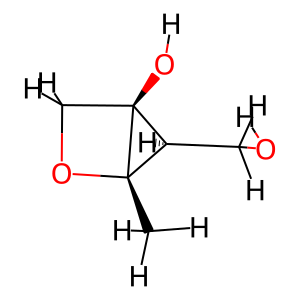

In [19]:
data = next(loader).to(device)
mol = data.mol[0]
mol

In [20]:
1+1

2

In [21]:
print(model.hparams["fully_connected"],
      model.hparams["local_global_model"],
      model.hparams["cutoff"],
      model.hparams["num_layers"])

False True 7.5 4


In [22]:
steps = model._hparams["num_diffusion_timesteps"]
with torch.no_grad():
    pos, traj = model.reverse_sampling(x=data.x,
                                       batch=data.batch,
                                       bond_edge_index=data.edge_index,
                                       bond_edge_attr=data.edge_attr,
                                       num_diffusion_timesteps=steps,
                                       save_traj=True,
                                       verbose=True)
pos_sde_traj, pos_mean_traj = traj

range(0, 300)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 100.38it/s]


In [23]:
print(pos.isnan().sum())
print(pos.max(), pos.min())

tensor(0, device='cuda:0')
tensor(3.3113, device='cuda:0') tensor(-2.6859, device='cuda:0')


In [24]:
original_mol = deepcopy(mol)
copied_mol = deepcopy(mol)

In [25]:
# nglview.show_rdkit(original_mol)
viewer = MolTo3DView(original_mol, size=(600, 300), style='stick')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [26]:
pos = pos_sde_traj[-1]
copied_mol = chem.set_rdmol_positions(copied_mol, pos=pos.detach().cpu().numpy())
# nglview.show_rdkit(copied_mol)
viewer = MolTo3DView(copied_mol, size=(600, 300), style='stick')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [27]:
mol_trajs = [None for i in range(len(pos_sde_traj))]
for i, p in enumerate(pos_sde_traj):
    mol_trajs[i] = chem.set_rdmol_positions(deepcopy(mol), pos=p.detach().cpu().numpy())

In [28]:
def conf_viewer(idx):
    mol = mol_trajs[idx]
    return MolTo3DView(mol).show()

In [29]:
interact(conf_viewer, idx=ipywidgets.IntSlider(min=0, max=len(mol_trajs) - 1, step=2))

interactive(children=(IntSlider(value=0, description='idx', max=299, step=2), Output()), _dom_classes=('widget…

<function __main__.conf_viewer(idx)>

## energy

In [30]:
print(compute_mmff_energy(mol=original_mol))
print(compute_mmff_energy(mol=copied_mol))

42.285599268194424
35.71237787463788


In [31]:
nrepeats = 100
batch = repeat_data(data, num_repeat=nrepeats)

In [32]:
batch

DataBatch(x=[1900, 5], edge_index=[2, 4000], edge_attr=[4000], atom_elements=[100], xgeom=[1900], pos=[1900, 3], mol=[100], smiles=[100], edge_index_fc=[2, 34200], energy=[100, 1], boltzmannweight=[100, 1], batch=[1900])

In [33]:
steps = model._hparams["num_diffusion_timesteps"]
with torch.no_grad():
    pos, traj = model.reverse_sampling(x=batch.x,
                                       batch=batch.batch,
                                       bond_edge_index=batch.edge_index,
                                       bond_edge_attr=batch.edge_attr,
                                       num_diffusion_timesteps=steps,
                                       save_traj=True, verbose=True)
pos_sde_traj, pos_mean_traj = traj

range(0, 300)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.94it/s]


In [34]:
pos = torch.stack(pos.chunk(nrepeats, dim=0))
pos = pos.cpu()

In [35]:
original_mol = deepcopy(mol)
nglview.show_rdkit(original_mol)

NGLWidget()

In [36]:
copied_mol = chem.set_rdmol_positions(copied_mol, pos=pos[0])
nglview.show_rdkit(copied_mol)

NGLWidget()

In [37]:
mol_trajs = [None for i in range(len(pos))]
for i, p in enumerate(pos):
    mol_trajs[i] = chem.set_rdmol_positions(deepcopy(mol), pos=p.detach().cpu().numpy())

In [38]:
interact(conf_viewer, idx=ipywidgets.IntSlider(min=0, max=len(mol_trajs) - 1, step=1))

interactive(children=(IntSlider(value=0, description='idx', max=99), Output()), _dom_classes=('widget-interact…

<function __main__.conf_viewer(idx)>

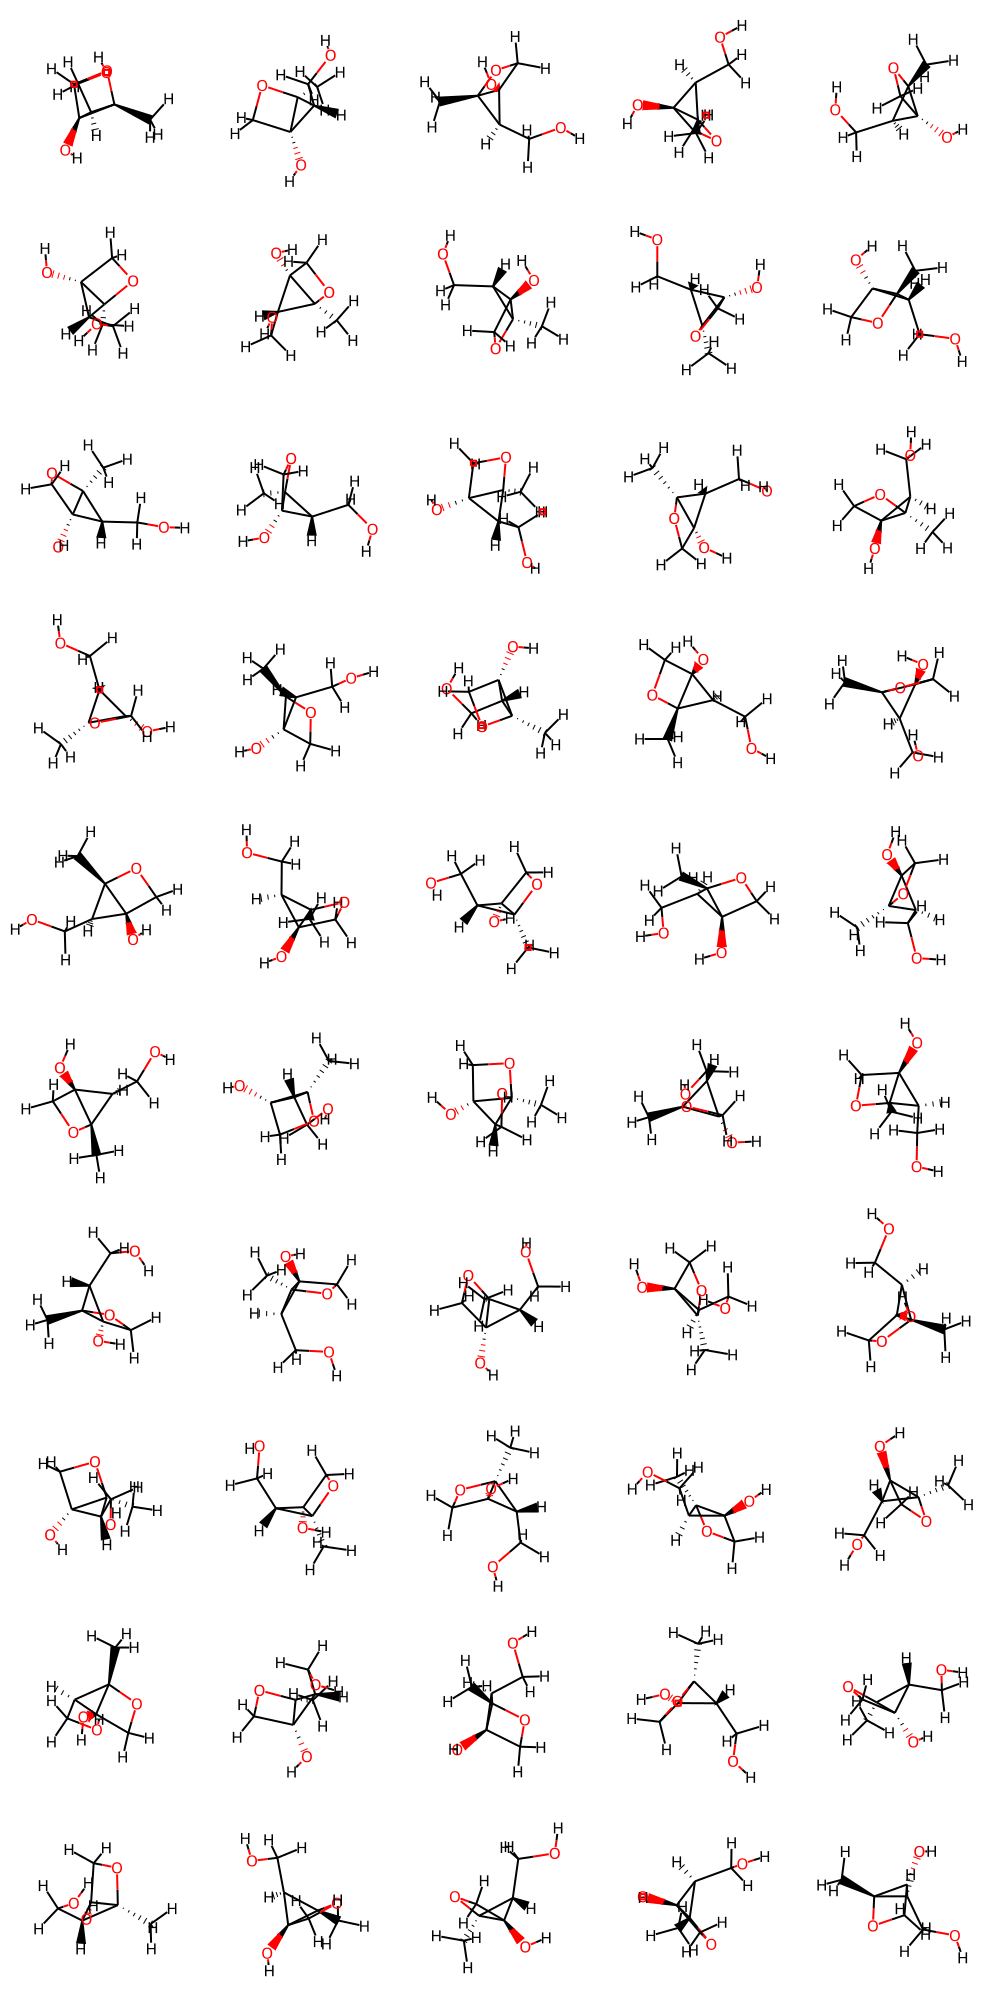

In [39]:
rdkit.Chem.Draw.MolsToGridImage(mol_trajs, molsPerRow=5, subImgSize=(200, 200))

### check if conformers are cluttered altogether

In [40]:
median_distances = np.array([torch.median(compute_distances(p)).item() for p in pos])

(array([1., 0., 1., 3., 0., 1., 3., 0., 0., 2., 3., 0., 1., 0., 1., 0., 1.,
        2., 0., 3., 2., 1., 1., 4., 3., 1., 3., 4., 2., 5., 4., 7., 3., 5.,
        2., 2., 3., 2., 4., 3., 2., 2., 3., 1., 2., 3., 0., 0., 2., 2.]),
 array([3.06112719, 3.06559402, 3.07006086, 3.0745277 , 3.07899454,
        3.08346138, 3.08792822, 3.09239506, 3.0968619 , 3.10132874,
        3.10579557, 3.11026241, 3.11472925, 3.11919609, 3.12366293,
        3.12812977, 3.13259661, 3.13706345, 3.14153028, 3.14599712,
        3.15046396, 3.1549308 , 3.15939764, 3.16386448, 3.16833132,
        3.17279816, 3.177265  , 3.18173183, 3.18619867, 3.19066551,
        3.19513235, 3.19959919, 3.20406603, 3.20853287, 3.21299971,
        3.21746655, 3.22193338, 3.22640022, 3.23086706, 3.2353339 ,
        3.23980074, 3.24426758, 3.24873442, 3.25320126, 3.25766809,
        3.26213493, 3.26660177, 3.27106861, 3.27553545, 3.28000229,
        3.28446913]),
 <BarContainer object of 50 artists>)

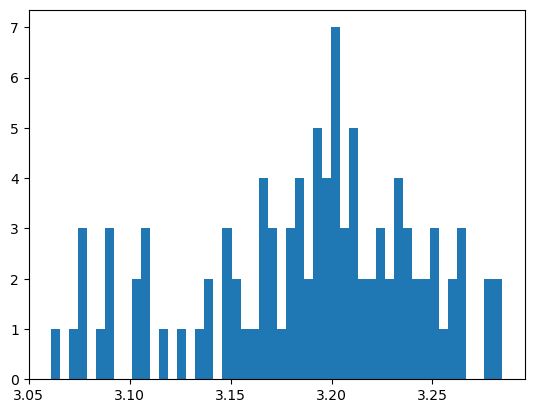

In [41]:
%matplotlib inline
plt.hist(median_distances, bins=50)

In [42]:
energies = np.array([compute_mmff_energy(mol) for mol in mol_trajs])

In [43]:
quantiles = np.quantile(energies, q=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

In [44]:
quantiles

array([ 40.11060315,  41.71117248,  43.41184784,  47.78890248,
        52.45865776, 106.04128615])

In [45]:
np.max(energies)

106.74455461271815